In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric import loader
from poker_utils.model import plot_train_loss
from poker_utils.constants import DECK_DICT
from uc_data import UCIrvineDataset

In [2]:
X = pd.read_csv("data/uc_irvine/X.csv")
y = pd.read_csv("data/uc_irvine/y.csv")
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.6, random_state=29, stratify=y['CLASS']
    )
X_train = X_train.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)
X_val = X_val.reset_index(drop=True)
y_val = y_val.reset_index(drop=True)

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [63]:
train_dataset = UCIrvineDataset(X_train, y_train, add_random_cards=True, use_card_ids=False,
                           graph=True, normalize_x=True)
val_dataset = UCIrvineDataset(X_val, y_val, add_random_cards=True, use_card_ids=True,
                           graph=True, normalize_x=True)


In [64]:
trainloader = loader.DataLoader(train_dataset, batch_size=128, shuffle=True)
valloader = loader.DataLoader(val_dataset, batch_size=128, shuffle=False)

In [65]:
ex_batch = next(iter(trainloader))

In [ ]:
class CardGNN(torch.nn.Module):
    def __init__(self, card_embeddings=None, in_dim=2, hidden_dim=16, out_dim=16, freeze_emb=True):
        super().__init__()
        self.freeze_emb = freeze_emb
        if card_embeddings is not None:
            padding_row = torch.zeros((1, card_embeddings.size(1)))
            card_embeddings_padded = torch.cat([card_embeddings, padding_row], dim=0) 
            self.card_embedder = nn.Embedding.from_pretrained(
                card_embeddings_padded, padding_idx=52, freeze=freeze_emb)
            
        if card_embeddings is not None:
            self.gcn1 = GCNConv(card_embeddings.size(1), hidden_dim, add_self_loops=True)
            self.use_card_emb = True
        else:
            self.gcn1 = GCNConv(in_dim, hidden_dim, add_self_loops=True)
            self.use_card_emb = False
        self.gcn2 = GCNConv(hidden_dim, out_dim, add_self_loops=True)
        self.out_dim = out_dim
    
    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        if self.use_card_emb:
            x = self.card_embedder(x.squeeze(-1))

        x = self.gcn1(x, edge_index)
        x = torch.relu(x)
        x = self.gcn2(x, edge_index)
        return x 

In [ ]:
class TransformerBoardEncoder(nn.Module):
    def __init__(self, gnn_encoder=None, card_embeddings=None, board_dim=16, 
                 num_heads=8, num_layers=2, freeze_emb=True):
        super().__init__()
        
        if gnn_encoder is not None:
            self.card_dim = gnn_encoder.out_dim
            self.gnn = gnn_encoder
            self.card_cls_tok = nn.Parameter(torch.randn(self.card_dim))
        else:
            self.gnn = None
            self.card_dim = card_embeddings.size(1)
            padding_row = torch.zeros((1, self.card_dim))
            card_embeddings_padded = torch.cat([card_embeddings, padding_row], dim=0) 
            self.card_embedder = nn.Embedding.from_pretrained(
                card_embeddings_padded, padding_idx=52, freeze=freeze_emb)
            
            self.card_cls_tok = nn.Parameter(torch.randn(1, 1, self.card_dim))
            
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=self.card_dim,
            nhead=num_heads,
            dropout=0.1,
            dim_feedforward=2*self.card_dim,
            batch_first=True
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.output_proj = nn.Linear(self.card_dim, board_dim)

    def forward(self, data):
        """
        data: PyG batch from DataLoader
        """
        if self.gnn is not None:
            x = self.gnn(data.x, data.edge_index)
            x_padded, pad_mask, unique_graph_ids = self.pack_graphs_with_cls(x, data.batch, self.card_cls_tok)
            x_trans = self.transformer(x_padded, src_key_padding_mask=pad_mask)

        else:
            B, L = data.shape
            mask = (data != -1)
            safe_ids = data.masked_fill(~mask, 52)
            card_emb = self.card_embedder(safe_ids)
            card_cls_tok = self.card_cls_tok.expand(B, 1, -1)
            card_emb = torch.cat([card_cls_tok, card_emb], dim=1)
        
            pad_mask = torch.cat([torch.zeros(B, 1, dtype=torch.bool), ~mask], dim=1)
            x_trans = self.transformer(card_emb, src_key_padding_mask=pad_mask)
            
        cls_out = x_trans[:, 0, :]
        output = self.output_proj(cls_out)
        
        if self.gnn is not None:
            y_valid = data.y[unique_graph_ids]
            return output, y_valid
        else:
            return output
    
    def pack_graphs_with_cls(self, x, batch, cls_token):
        unique_graph_ids = batch.unique()
        graph_seqs = []
        for i in unique_graph_ids:
            seq = x[batch == i]
            if seq.size(0) == 0:
                continue
            cls = cls_token.unsqueeze(0) 
            graph_seqs.append(torch.cat([cls, seq], dim=0))  
        padded = nn.utils.rnn.pad_sequence(graph_seqs, batch_first=True) 
        mask = torch.ones(padded.shape[:2], dtype=torch.bool, device=x.device)
        for i, seq in enumerate(graph_seqs):
            mask[i, :seq.size(0)] = False
        return padded, mask, unique_graph_ids


    

In [ ]:
card_embeddings = torch.load('embeddings/card_embeddings.pt', weights_only=True)

In [70]:
class HandStrengthPredictor(nn.Module):
    def __init__(self, card_embeddings, card_dim=16, board_dim=16, num_heads=8, num_layers=2, freeze_emb=True):
        super().__init__()
        self.board_encoder = TransformerBoardEncoder(
            card_embeddings,
            card_dim=card_dim, 
            board_dim=board_dim, 
            num_heads=num_heads, 
            num_layers=num_layers,
            freeze_emb=freeze_emb
        )
        self.output_layer = nn.Linear(board_dim, 10)  # 10 poker hand classes

    def forward(self, data):
        board_repr, y_valid = self.board_encoder(data)
        logits = self.output_layer(board_repr)
        return logits, y_valid


In [71]:
def train_model(model, trainloader, optimizer, scheduler=None, device=None, 
                valloader=None, epochs=50,leftoff=0,save=True):
    
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []
    class_weights = torch.load("model_weights/class_weights.pt", weights_only=True)
    for epoch in range(epochs):
        tot_train_loss = 0
        correct_train = 0
        total_train = 0

        model.train()
        for batch_data in trainloader:
            optimizer.zero_grad()
            # hand, board, strength = [x.to(device) for x in batch] if device is not None else batch
            logits, strength = model(batch_data)
            batch_loss = F.cross_entropy(logits, strength, weight=class_weights)
            batch_loss.backward()
            optimizer.step()
            
            tot_train_loss += batch_loss.item()
            preds = logits.argmax(dim=1)
            correct_train += (preds == strength).sum().item()
            total_train += strength.size(0)

        avg_train_loss = tot_train_loss / len(trainloader)
        train_acc = correct_train / total_train
        train_losses.append(avg_train_loss)
        train_accuracies.append(train_acc)

        if valloader is not None:
            model.eval()
            tot_val_loss = 0
            correct_val = 0
            total_val = 0

            with torch.no_grad():
                for batch_data in valloader:
                    # hand, board, strength = [x.to(device) for x in batch] if device is not None else batch
                    logits, strength = model(batch_data)
                    batch_loss = F.cross_entropy(logits, strength, weight=class_weights)
                    tot_val_loss += batch_loss.item()
                    preds = logits.argmax(dim=1)
                    correct_val += (preds == strength).sum().item()
                    total_val += strength.size(0)

            avg_val_loss = tot_val_loss / len(valloader)
            val_acc = correct_val / total_val
            val_losses.append(avg_val_loss)
            val_accuracies.append(val_acc)

        if valloader is not None:
            print(f"Epoch {epoch+1}/{epochs}, Train Loss: {avg_train_loss:.4f}, Train Acc: {train_acc:.4f}, "
                  f"Val Loss: {avg_val_loss:.4f}, Val Acc: {val_acc:.4f}")
        else:
            print(f"Epoch {epoch+1}/{epochs}, Train Loss: {avg_train_loss:.4f}, Train Acc: {train_acc:.4f}")
        if save:
            if (epoch + 1) % 5 == 0:
                torch.save(model.state_dict(), f"model_weights/hand_strength_predictor{leftoff+epoch+1}.pth")
                   
        if scheduler is not None:
                scheduler.step()
                
    if valloader is not None:
        return {"train_loss":train_losses, 
                "val_loss":val_losses, 
                "train_accuracy":train_accuracies, 
                "val_accuracy":val_accuracies}
    else:
        return {'train_loss':train_losses, "train_accuracy":train_accuracies}


In [72]:
card_embeddings = torch.load('embeddings/card_embeddings.pt', weights_only=True)

In [73]:
model = HandStrengthPredictor(
        card_embeddings=card_embeddings,
        card_dim=16,
        board_dim=16,
        num_heads=8, 
        num_layers=4, 
        freeze_emb=True
        ).to(device)

In [74]:
def partial_load(model, checkpoint, layer_name='board_encoder'):
    current_state_dict = model.state_dict()
    filtered_state_dict = {
        name: param for name, param in current_state_dict.items()
        if (name.startswith(layer_name))
        and name in current_state_dict
        and current_state_dict[name].shape == param.shape
        }
    model.load_state_dict(filtered_state_dict, strict=False)

In [ ]:
# state_dict = torch.load("model_weights/hand_strength_predictor200.pth", weights_only=True)
# partial_load(model, state_dict)
# model.load_state_dict(state_dict)

<All keys matched successfully>

In [75]:
optimizer = torch.optim.Adam(model.parameters(), lr= 1e-3)
# scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=25, gamma=0.5)

In [76]:
res = train_model(
        model=model,
        trainloader=trainloader,
        valloader=valloader,
        optimizer=optimizer, 
        scheduler=None,
        device=None,
        epochs=3,
        leftoff=0,
        save=False
        )

c:\Users\campb\miniconda3\envs\poker_env\lib\site-packages\torch\nn\modules\transformer.py:502: UserWarning: The PyTorch API of nested tensors is in prototype stage and will change in the near future. (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\NestedTensorImpl.cpp:180.)
  output = torch._nested_tensor_from_mask(


Epoch 1/3, Train Loss: 1.8648, Train Acc: 0.3407, Val Loss: 1.6485, Val Acc: 0.4413
Epoch 2/3, Train Loss: 1.6388, Train Acc: 0.3994, Val Loss: 1.6041, Val Acc: 0.4609
Epoch 3/3, Train Loss: 1.5567, Train Acc: 0.4153, Val Loss: 1.4960, Val Acc: 0.3604


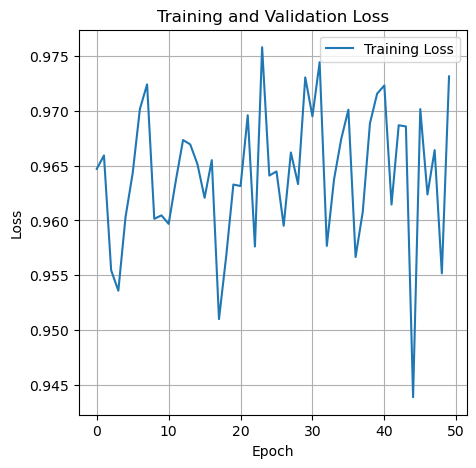

In [26]:
plot_train_loss(res['val_accuracy'])

In [13]:
def get_classification_report(model, dataloader, device=None):
    all_preds = []
    all_labels = []
    all_indices = []
    class_names = [
        "nothing", "one_pair", "two_pair", "three_of_a_kind", "straight",
        "flush", "full_house", "four_of_a_kind", "straight_flush", "royal_flush"
        ]
    model.eval()
    with torch.no_grad():
        for i, batch in enumerate(dataloader):
            hand, board, labels = [x.to(device) for x in batch] if device is not None else batch
            outputs = model(hand,  board)
            preds = outputs.argmax(dim=1)
            all_preds.append(preds.cpu())
            all_labels.append(labels.cpu())
            all_indices.extend(range(i * dataloader.batch_size, (i + 1) * dataloader.batch_size))
    all_preds = torch.cat(all_preds)
    all_labels = torch.cat(all_labels)
    report = classification_report(all_labels, all_preds, target_names=class_names)
    cm = confusion_matrix(all_labels, all_preds)
    return {'report':report, 'confusion_matrix':cm,'labels':all_labels,'pred':all_preds}


In [28]:
res = get_classification_report(model, valloader)

c:\Users\campb\miniconda3\envs\poker_env\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\campb\miniconda3\envs\poker_env\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\campb\miniconda3\envs\poker_env\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(r

In [29]:
print(res['report'])

                 precision    recall  f1-score   support

        nothing       1.00      0.96      0.98    308221
       one_pair       1.00      0.98      0.99    259858
       two_pair       0.99      1.00      0.99     29297
three_of_a_kind       0.99      1.00      1.00     12980
       straight       0.26      0.97      0.41      2387
          flush       0.09      0.63      0.15      1230
     full_house       0.99      1.00      0.99       876
 four_of_a_kind       1.00      0.99      1.00       142
 straight_flush       0.00      0.00      0.00        10
    royal_flush       0.00      0.00      0.00         5

       accuracy                           0.97    615006
      macro avg       0.63      0.75      0.65    615006
   weighted avg       0.99      0.97      0.98    615006



In [30]:
class_names = [
        "High Card", "Pair", "Two Pair", "Three of a Kind", "Straight",
        "Flush", "Full House", "Four of a Kind", "Straight Flush", "Royal Flush"
        ]

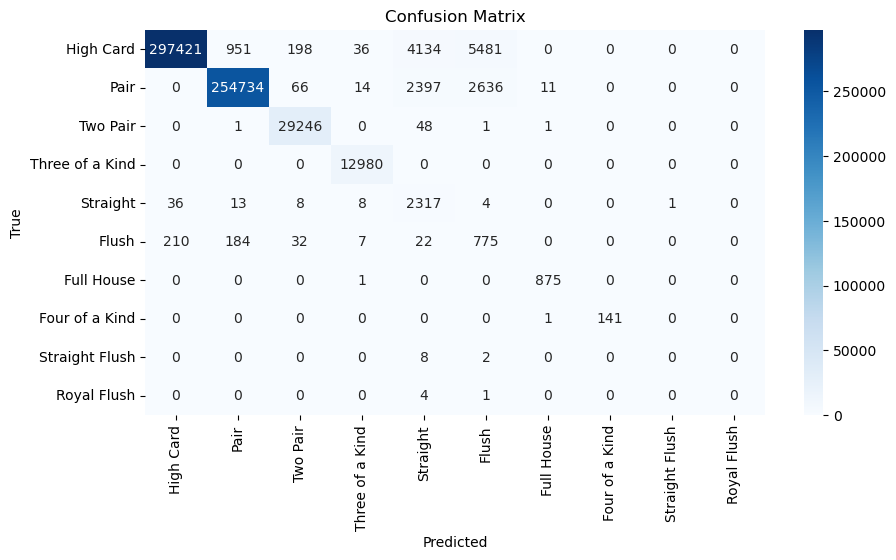

In [31]:
plt.figure(figsize=(10, 5))
sns.heatmap(res['confusion_matrix'], annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()


In [36]:
model.eval()
with torch.no_grad():
    card_emb = model.board_encoder.card_embedder.weight.detach().numpy()

In [49]:
from sklearn.decomposition import PCA
from poker_utils.constants import DECK_DICT

In [45]:
old_card_emb = torch.load("embeddings/card_embeddings.pt", weights_only=True).numpy()

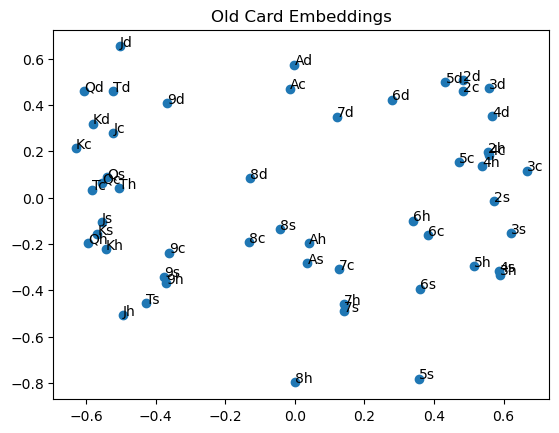

In [52]:
pca = PCA(n_components=2)
old_emb_2d = pca.fit_transform(old_card_emb)

plt.scatter(old_emb_2d[:,0], old_emb_2d[:,1])
for i, txt in enumerate(DECK_DICT.values()):
    plt.annotate(txt, (old_emb_2d[i,0], old_emb_2d[i,1]))
plt.title("Old Card Embeddings")
plt.show()

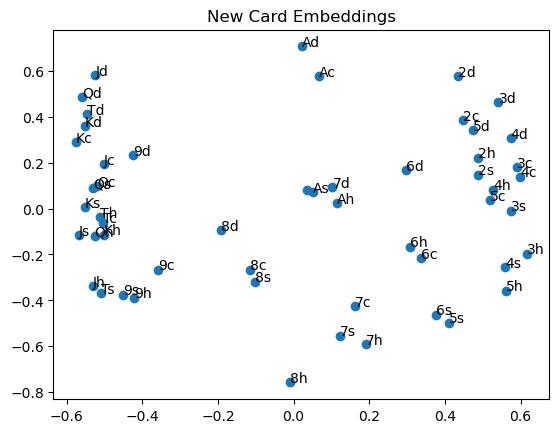

In [53]:
pca = PCA(n_components=2)
old_emb_2d = pca.fit_transform(card_emb)

plt.scatter(old_emb_2d[:,0], old_emb_2d[:,1])
for i, txt in enumerate(DECK_DICT.values()):
    plt.annotate(txt, (old_emb_2d[i,0], old_emb_2d[i,1]))
plt.title("New Card Embeddings")
plt.show()